In [1]:
import numpy as np
import matplotlib.pyplot as plt

total_particle_number = 1.0e8
PMass = 2.0975e15 / 1.989e33
Mtot = PMass * total_particle_number

def load_halo_out_data(PATH, num):
    full_halo_data = np.loadtxt(PATH + 'out_' + str(num) + '.list',
                                delimiter=' ', dtype=float, comments='#')
    int_id = full_halo_data[:, 1]
    NPart = full_halo_data[:, 7]
    i = 0
    sub_count = 0
    while i < len(NPart):
        if NPart[i] == 0.0:
            NPart = np.delete(NPart, i)
        #elif int_id[i] != 1:
        #        NPart = np.delete(NPart, i)
        #        sub_count += 1
        else:
            i += 1
        
    HMass = PMass * NPart
    print('Sub-Halo Count: ' + str(sub_count))
    return NPart, HMass;

def make_histogram(array, Nbins):
    hist, bins = np.histogram(array, bins=np.logspace(np.log10(np.min(array)),
                            np.log10(np.max(array)),Nbins))
    return hist, bins;

def hmf(hist, bins):
    dn_dlogM  = np.zeros(np.shape(hist))
    df_dlogM  = np.zeros(np.shape(hist))
    masses    = np.zeros(np.shape(hist))
    errors_dn = np.zeros(np.shape(hist))
    errors_df = np.zeros(np.shape(hist))
    for i in range(len(hist)):
        dlogM = (np.log10(bins[i+1]) - np.log10(bins[i]))
        dn_dlogM[i] = hist[i] / dlogM
        masses[i] = 0.5 * (bins[i+1] + bins[i])
        df_dlogM[i] = masses[i] * dn_dlogM[i] / Mtot
        errors_dn[i] = np.sqrt(hist[i]) / dlogM
        errors_df[i] = masses[i] * errors_dn[i] / Mtot
    
    return masses, dn_dlogM, errors_dn, df_dlogM, errors_df;

def plot_hmf(PATH, num, z):
    NPart, HMass = load_halo_out_data(PATH, num)
    hist, bins = make_histogram(HMass, 50)
    masses, dn_dlogM, errors_dn, df_dlogM, errors_df = hmf(hist, bins)
    if num == 26:
        plt.errorbar(masses[:], df_dlogM[:], yerr=errors_df[:], fmt='o', capsize=5, label='z = %.1f' % z)
    else:
        plt.errorbar(masses, df_dlogM, yerr=errors_df, fmt='o', capsize=5, label='z = %.1f' % z)
    return;

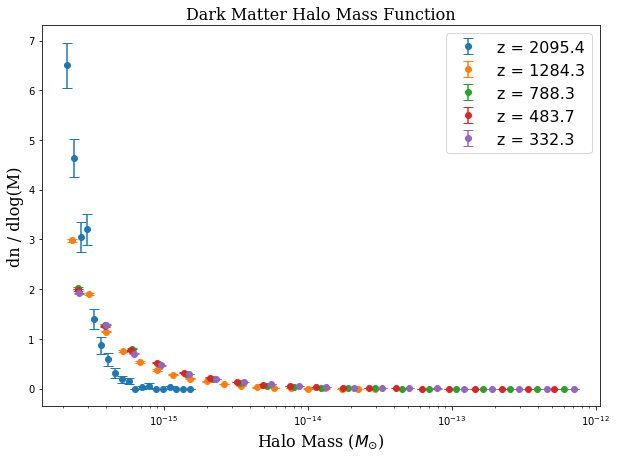

In [11]:
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_sim/output_z3412_z300/'
plt.figure(figsize=(10, 7))
#a_list = [0.000163, 0.000265, 0.000432, 0.000704, 0.001000]
#out_list_list = [10, 20, 30, 40, 48]
a_list = [0.000477, 0.000778, 0.001267, 0.002063, 0.003000]
out_list_list = [10, 20, 30, 40, 48]
for i in range(5):
    plot_hmf(PATH, out_list_list[i], -1.0 + 1.0 / a_list[i])
#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
plt.ylabel(r'dn / dlog(M)', fontsize=16, fontname='serif')
plt.title(r'Dark Matter Halo Mass Function', fontsize=16, fontname='serif')
plt.legend(fontsize=16)
plt.savefig(PATH + 'halo_mass_function.png', dpi=1000)
plt.show()

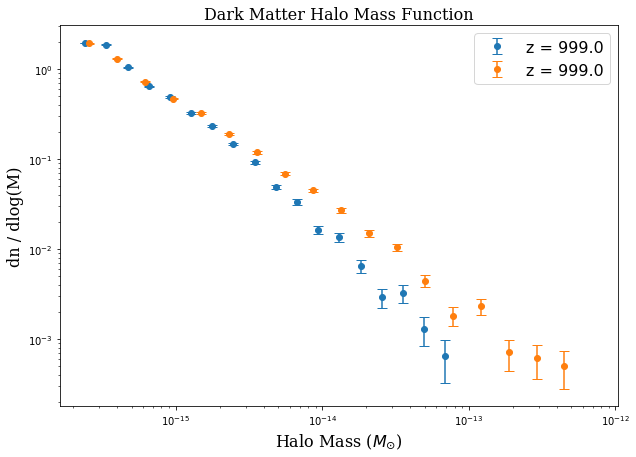

In [10]:
PATH1 = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_sim/output_z3412_z300/'
PATH2 = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_sim/output_z10000_z1000/'
plt.figure(figsize=(10, 7))
plot_hmf(PATH1, 26, 1.0 / 0.001 - 1.0)
plot_hmf(PATH2, 48, 1.0 / 0.001 - 1.0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
plt.ylabel(r'dn / dlog(M)', fontsize=16, fontname='serif')
plt.title(r'Dark Matter Halo Mass Function', fontsize=16, fontname='serif')
plt.legend(fontsize=16)
plt.savefig('halo_mass_function.png', dpi=1000)
plt.show()

In [15]:
PMass = 2.0975e15 / 1.989e33
num = 49

PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_20.08.19/output/'
NPart1, HMass1 = load_halo_out_data(PATH, num)

num = 44
PMass = 4.00632e16 / 1.989e33
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_sim/output_z10000_z1000/'
NPart2, HMass2 = load_halo_out_data(PATH, num)

PMass = 5.18729e13 / 1.989e33
num = 26
PATH = '/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/miniclusters_hires/output/halos/'
NPart3, HMass3 = load_halo_out_data(PATH, num)

Sub-Halo Count: 0
Sub-Halo Count: 0
Sub-Halo Count: 0


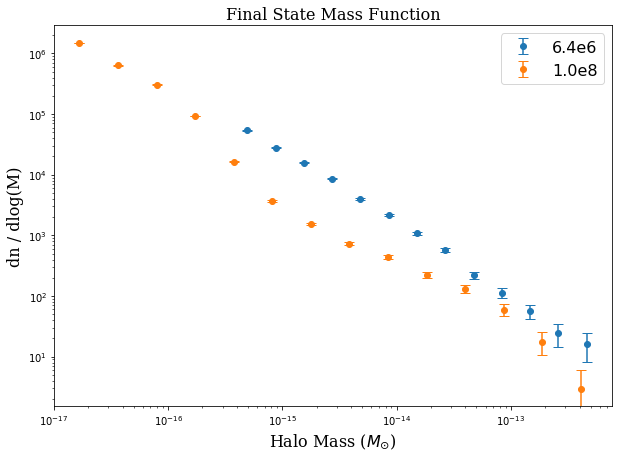

In [19]:
hist1, bins1 = make_histogram(HMass1, 15)
masses1, dn_dlogM1, errors_dn1, df_dlogM1, errors_df1 = hmf(hist1, bins1)
hist2, bins2 = make_histogram(HMass2, 15)
masses2, dn_dlogM2, errors_dn2, df_dlogM2, errors_df2 = hmf(hist2, bins2)
hist3, bins3 = make_histogram(HMass3, 15)
masses3, dn_dlogM3, errors_dn3, df_dlogM3, errors_df3 = hmf(hist3, bins3)

z = 1 / 0.000739 - 1
plt.figure(figsize=(10, 7))
plt.errorbar(masses2[1:], dn_dlogM2[1:], yerr=errors_dn2[1:], fmt='o', capsize=5, label='6.4e6')
#plt.errorbar(masses3, dn_dlogM3, yerr=errors_dn3, fmt='o', capsize=5, label='6.4e7')
plt.errorbar(masses1, dn_dlogM1, yerr=errors_dn1, fmt='o', capsize=5, label='1.0e8')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Halo Mass ($M_{\odot}$)', fontsize=16, fontname='serif')
plt.ylabel(r'dn / dlog(M)', fontsize=16, fontname='serif')
plt.title(r'Final State Mass Function', fontsize=16, fontname='serif')
plt.legend(fontsize=16)
plt.savefig('halo_mass_function.png', dpi=1000)
plt.show()